## Building basic likelihoods

In [1]:
import sys
import os
import glob
import importlib

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

In [5]:
import discovery.metamatrix as mm
import discovery.metamath as mh

Read nanograv pulsars

In [6]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

In [7]:
psr = allpsrs[0]

In [8]:
importlib.reload(mm)
importlib.reload(mh)
importlib.reload(ds.likelihood)
importlib.reload(ds)

<module 'discovery' from '/Users/pmeyers/Repositories/discovery/main_fork/discovery/src/discovery/__init__.py'>

## Graph tests

Simple graph, all constants, will be reduced to constant.

In [9]:
@mm.graph
def sumtwo(graph, a, b):
    a2 = 2 * a
    b3 = 3 * b
    result = a2 + b3

In [10]:
g = sumtwo(1,2)

In [11]:
mm.print_graph(g);

## graph
a: const = 1
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


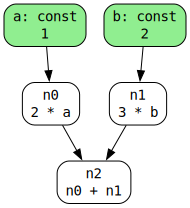

In [12]:
mm.visualize_graph(g)

Now `fold_constants` prunes directly

In [13]:
g1 = mm.fold_constants(g)

In [14]:
mm.print_graph(g1);

## graph
n2: const = 8
# total array constants: 0 elements


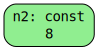

In [15]:
mm.visualize_graph(g1)

In [16]:
f = mm.func(g1)

In [17]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 [])

In [18]:
f()

8

Now with one argument, will be reduced partially, and create a function of one argument.

In [19]:
g = sumtwo(None, 2)

In [20]:
mm.print_graph(g);

## graph
a: arg
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


In [21]:
g1 = mm.fold_constants(g)

In [22]:
mm.print_graph(g1);

## graph
a: arg
n0: node(a) = 2 * a
n1: const = 6
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


In [23]:
f = mm.func(g)

In [24]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [])

In [25]:
f(5)

16

In [26]:
f = mm.func(g1)

In [27]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [])

In [28]:
f(5)

16

One of the inputs is a graph. Everything folded.

In [29]:
@mm.graph
def double(graph, a):
    res = 2.5 * a

In [30]:
@mm.graph
def sumtwo(graph, a, b, f):
    result = f(a) + 3 * b

In [31]:
g = sumtwo(2, 3, double(None))

In [32]:
mm.print_graph(g)

## graph
a: const = 2
b: const = 3
f: graph = subgraph f[4d3e]
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f[4d3e]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


0

In [33]:
g1 = mm.fold_constants(sumtwo(2, 3, double(None)))

In [34]:
mm.print_graph(g1)

## graph
n2: const = 14.0
# total array constants: 0 elements


0

In [35]:
f = mm.func(g1)

In [36]:
f, f.args, f.params, f()

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 [],
 14.0)

One of the inputs is a function, cannot be evaluated immediately.

In [37]:
g = sumtwo(None, 3, double(None))

In [38]:
mm.print_graph(g)

## graph
a: arg
b: const = 3
f: graph = subgraph f[891e]
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f[891e]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


0

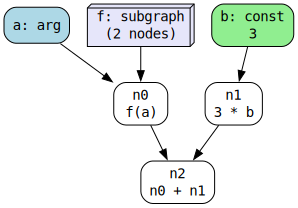

In [39]:
mm.visualize_graph(g)

In [40]:
g1 = mm.fold_constants(g)

In [41]:
mm.print_graph(g1);

## graph
a: arg
f_n0: graph = subgraph f_n0[cc09]
n0: node(f_n0, a) = f(a)
n1: const = 9
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f_n0[cc09]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


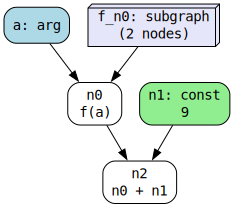

In [42]:
mm.visualize_graph(g1)

In [43]:
f = mm.func(g1)

In [44]:
f, f.args, f.params, f(4)

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [],
 19.0)

## Discovery components

Simple noise solver

In [45]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

All constants

In [46]:
yvec = psr.residuals
Nvec = ds.makenoise_measurement(psr, noisedict=psr.noisedict).N

In [47]:
Nsolve = noisesolve(yvec, Nvec)

In [48]:
mm.print_graph(Nsolve)

## graph
y: const = array(7758,)
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array constants: 15516 elements


15516

In [49]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
n0: const = array(7758,), array()
# total array constants: 7759 elements


7759

First empty argument

In [50]:
Nsolve = noisesolve(None, Nvec)

In [51]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: arg
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [52]:
f = mm.func(Nsolve)

In [53]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['y'],
 [])

In [54]:
f(yvec)

(array([-924684.05643357,  -15209.00619106, -256184.91074607, ...,
         457218.89618558, 3758690.70368335, 1397786.82265916],
       shape=(7758,)),
 Array(-209930.62020633, dtype=float64))

Works also for a matrix

In [55]:
Fmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).F

In [56]:
f(Fmat)

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.05907192e+11],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.94299584e+12],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.57914432e+11]],
       shape=(7758, 360)),
 Array(-209930.62020633, dtype=float64))

What if N is a function?

In [57]:
Nfunc = ds.makenoise_measurement(psr).getN

In [58]:
Nfunc.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [59]:
Nsolve = noisesolve(yvec, Nfunc)

In [60]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: const = array(7758,)
N: func = <function makenoise_measurement.<locals>.getnoise at 0x39fc3ab60>
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [61]:
f = mm.func(Nsolve)

In [62]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 ['B1855+09_430_ASP_efac',
  'B1855+09_430_ASP_log10_t2equad',
  'B1855+09_430_PUPPI_efac',
  'B1855+09_430_PUPPI_log10_t2equad',
  'B1855+09_L-wide_ASP_efac',
  'B1855+09_L-wide_ASP_log10_t2equad',
  'B1855+09_L-wide_PUPPI_efac',
  'B1855+09_L-wide_PUPPI_log10_t2equad'])

In [63]:
f(params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([-1296090.89249524,   -20181.85263898,  -349506.29641867, ...,
           31224.68377662,    28572.25240899,    36464.08538401],      dtype=float64),
 Array(-188767.30337409, dtype=float64))

Now keep y open

In [64]:
Nsolve = noisesolve(None, Nfunc)

In [65]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: arg
N: func = <function makenoise_measurement.<locals>.getnoise at 0x39fc3ab60>
n0: node(N, y) = solve(N, y)
# total array constants: 0 elements


0

In [66]:
f = mm.func(Nsolve)

In [67]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['y'],
 ['B1855+09_430_ASP_efac',
  'B1855+09_430_ASP_log10_t2equad',
  'B1855+09_430_PUPPI_efac',
  'B1855+09_430_PUPPI_log10_t2equad',
  'B1855+09_L-wide_ASP_efac',
  'B1855+09_L-wide_ASP_log10_t2equad',
  'B1855+09_L-wide_PUPPI_efac',
  'B1855+09_L-wide_PUPPI_log10_t2equad'])

In [68]:
f(yvec, params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([-1115113.20303251,   -17275.40879244,  -299935.47180176, ...,
           35429.21048527,    32900.87539817,    41799.30956809],      dtype=float64),
 Array(-189967.67679499, dtype=float64))

Prior inverse

In [69]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [70]:
Pmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).Phi.N

In [71]:
Pinv = noiseinv(Pmat)

In [72]:
mm.print_graph(mm.fold_constants(Pinv))

## graph
n0: const = array(360, 360), array()
# total array constants: 129601 elements


129601

In [73]:
jnp.all(mm.func(Pinv)(params = {})[0] == jnp.diag(1/Pmat))

Array(True, dtype=bool)

In [74]:
Pfunc = ds.makegp_ecorr(psr).Phi.getN

In [75]:
Pfunc.params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [76]:
Pinv = noiseinv(Pfunc)

In [77]:
mm.print_graph(mm.fold_constants(Pinv))

## graph
P: func = <function makegp_ecorr.<locals>.getphi at 0x39fe0d760>
n0: node(P) = inv(P)
# total array constants: 0 elements


0

In [78]:
mm.func(Pinv).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [79]:
mm.func(Pinv)(params=ds.sample_uniform(mm.func(Pinv).params))

(Array([[2.08040847e+13, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.08040847e+13, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.08040847e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.12944085e+14, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.12944085e+14, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.12944085e+14]], dtype=float64),
 Array(-12115.56087707, dtype=float64))

Woodbury

In [80]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [81]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [82]:
@mm.graph
def woodbury(graph, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = graph.cho_factor(Pm + FtNmF)

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ graph.cho_solve(cf, FtNmy)) - 0.5 * (lN + lP + lS)

In [83]:
Nsolve = noisesolve(None, Nvec)
mm.print_graph(Nsolve)

## graph
y: arg
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [84]:
Pinv = noiseinv(Pfunc)
mm.print_graph(Pinv)

## graph
P: func = <function makegp_ecorr.<locals>.getphi at 0x39fe0d760>
n0: node(P) = inv(P)
# total array constants: 0 elements


0

In [85]:
onewood = woodbury(yvec, Nsolve, Fmat, Pinv)

In [86]:
mm.print_graph(onewood)

## graph
y: const = array(7758,)
Nsolve: graph = subgraph Nsolve[e4b4]
F: const = array(7758, 360)
Pinv: graph = subgraph Pinv[a83a]
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: node(F) = F.T
n4: node(n3, n1) = n3 @ n1
n5: node(Nsolve, F) = Nsolve(F)
n6: node(n5) = n5[0]
n7: node(n5) = n5[1]
n8: node(F) = F.T
n9: node(n8, n6) = n8 @ n6
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = y.T
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = n4.T
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 2800638 elements

## subgraph Nsolve[e4b4]
y: arg
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array c

2808396

In [87]:
mm.print_graph(mm.fold_constants(onewood))

## graph
Pinv: graph = subgraph Pinv[8285]
n2: const = array()
n4: const = array(360,)
n9: const = array(360, 360)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = 16556.999978853702
n18: const = array(360,)
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 130321 elements

## subgraph Pinv[8285]
P: func = <function makegp_ecorr.<locals>.getphi at 0x39fe0d760>
n0: node(P) = inv(P)
# total array constants: 0 elements


130321

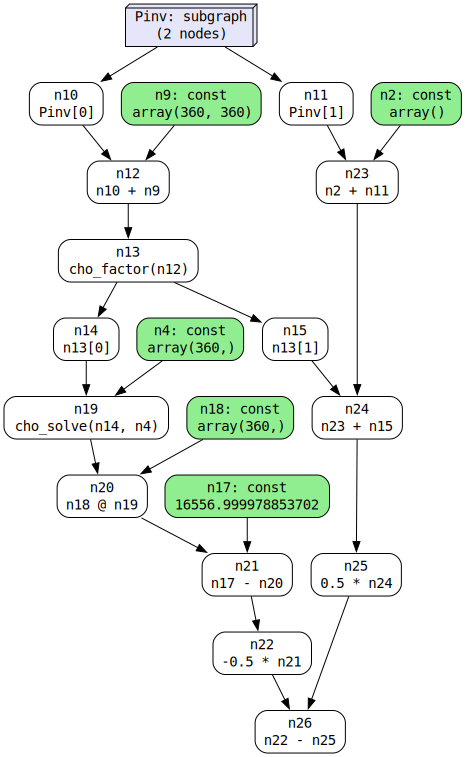

In [88]:
mm.visualize_graph(mm.fold_constants(onewood))

In [89]:
mm.func(onewood)(params = ds.sample_uniform(mm.func(onewood).params))

Array(100023.42997301, dtype=float64)

## Discovery likelihood

#### Measurement noise only

In [90]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement_simple(psr)])

In [91]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [92]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [93]:
@mm.graph
def normal(g, y, Nsolve):
    Nmy, lN = Nsolve(y).split()
    logp = -0.5 * (y.T @ Nmy) - 0.5 * lN

In [94]:
class NoiseMatrix:
    def __init__(self, N):
        self.N = N

    @property
    def make_solve(self):
        return noisesolve(None, self.N)

    @property
    def make_inv(self):
        return noiseinv(self.N)

In [95]:
ds.signals.matrix.NoiseMatrix1D_novar = NoiseMatrix
ds.signals.matrix.NoiseMatrix1D_var = NoiseMatrix

In [96]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [97]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

## graph
n7: const = array()
# total array constants: 1 elements


1

In [98]:
mm.func(graph)()

Array(96686.81011374, dtype=float64)

In [99]:
N = ds.makenoise_measurement(psr)
graph = normal(psr.residuals, N.make_solve)

In [100]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

## graph
n0: graph = subgraph n0[43b1]
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(7758,)
n4: node(n3, n1) = n3 @ n1
n5: node(n4) = -0.5 * n4
n6: node(n2) = 0.5 * n2
n7: node(n5, n6) = n5 - n6
# total array constants: 7758 elements

## subgraph n0[43b1]
y: const = array(7758,)
N: func = <function makenoise_measurement.<locals>.getnoise at 0x39fe0f560>
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


15516

In [101]:
mm.func(graph).params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [102]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(91687.85141432, dtype=float64)

#### Add ECORR noise

In [103]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr),
#                          ds.makegp_ecorr(psr)])

In [104]:
@mm.graph
def woodbury(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.cho_factor(Pm + FtNmF)

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ g.cho_solve(cf, FtNmy)) - 0.5 * (lN + lP + lS)

In [105]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [106]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
egp = ds.makegp_ecorr(psr)
graph = woodbury(psr.residuals, N.make_solve, egp.F, egp.Phi.make_inv)

In [107]:
mm.print_graph(graph)

## graph
y: const = array(7758,)
Nsolve: graph = subgraph Nsolve[edda]
F: const = array(7758, 360)
Pinv: graph = subgraph Pinv[44ad]
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: node(F) = F.T
n4: node(n3, n1) = n3 @ n1
n5: node(Nsolve, F) = Nsolve(F)
n6: node(n5) = n5[0]
n7: node(n5) = n5[1]
n8: node(F) = F.T
n9: node(n8, n6) = n8 @ n6
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = y.T
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = n4.T
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 2800638 elements

## subgraph Nsolve[edda]
y: arg
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array c

2808396

In [108]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

## graph
Pinv: graph = subgraph Pinv[e8c7]
n2: const = array()
n4: const = array(360,)
n9: const = array(360, 360)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = 16556.999978853702
n18: const = array(360,)
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 130321 elements

## subgraph Pinv[e8c7]
P: func = <function makegp_ecorr.<locals>.getphi at 0x3c09623e0>
n0: node(P) = inv(P)
# total array constants: 0 elements


130321

In [109]:
mm.func(graph).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [110]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(98359.10123773, dtype=float64)

#### Constant GP + variable GP

In [111]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [112]:
importlib.reload(mm)

<module 'discovery.metamatrix' from '/Users/pmeyers/Repositories/discovery/main_fork/discovery/src/discovery/metamatrix.py'>

In [113]:
@mm.graph
def woodburysolve(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.cho_factor(Pm + FtNmF)

    solve = Nmy - NmF @ g.cho_solve(cf,FtNmy)
    ld = lN + lP + lS

    result = g.pair(solve, ld)

In [114]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

In [115]:
graph1 = woodburysolve(None, N.make_solve, tgp.F, tgp.Phi.make_inv)

In [116]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph1)))

## graph
y: arg
Nsolve_n0: graph = subgraph Nsolve_n0[6cec]
n0: node(Nsolve_n0, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(166, 7758)
n4: node(n3, n1) = n3 @ n1
n6: const = array(7758, 166)
n11: const = array()
n14: const = array(166, 166), True
n15: const = array()
n16: node(n14, n4) = cho_solve(n14, n4)
n17: node(n6, n16) = n6 @ n16
n18: node(n1, n17) = n1 - n17
n19: node(n2, n11) = n2 + n11
n20: node(n19, n15) = n19 + n15
n21: node(n18, n20) = pair(n18, n20)
# total array constants: 2603214 elements

## subgraph Nsolve_n0[6cec]
y: arg
N: const = array(7758,)
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


2610972

In [117]:
graph2 = woodbury(yvec, graph1, rgp.F, rgp.Phi.make_inv)

In [118]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph2)))

## graph
Pinv: graph = subgraph Pinv[ff92]
n2: const = array()
n4: const = array(60,)
n9: const = array(60, 60)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array()
n18: const = array(60,)
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 3722 elements

## subgraph Pinv[ff92]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x3d09268e0>
n0: node(P) = inv(P)
# total array constants: 0 elements


3722

In [119]:
mm.func(graph2).params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [120]:
mm.func(graph2)(params=ds.sample_uniform(mm.func(graph2).params))

Array(90863.31864428, dtype=float64)

### Full single likelihood

In [121]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_ecorr(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [122]:
@mm.graph
def concat(g, a, b):
    result = g.node(lambda x, y: jnp.hstack([x, y]), [a, b])

In [123]:
import functools

class CompoundGP:
    def __init__(self, gplist):
        self.gplist = gplist

    @property
    def F(self):
        return functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.F for gp in self.gplist])

    @property
    def Phi(self):
        # won't work for 2D priors
        N = functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.Phi.N for gp in self.gplist])
        return NoiseMatrix(N)

In [124]:
@mm.graph
def delay(g, y, d):
    result = y - d

In [125]:
def CompoundDelay(residuals, delays):
    return functools.reduce(lambda x, y: mm.func(delay(x, y)), [residuals, *delays])

#### Clean example

In [126]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)

egp = ds.makegp_ecorr(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
cgp = CompoundGP([egp, tgp])

graph1 = woodburysolve(None, N.make_solve, cgp.F, cgp.Phi.make_inv)

cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']
yd = CompoundDelay(yvec, [ds.makedelay(psr, ds.makedelay_binary(pulsarterm=True), common=cwcommon, name='cw')])

rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

graph2 = woodbury(yd, graph1, rgp.F, rgp.Phi.make_inv)

logp = mm.func(graph2)

In [127]:
mm.print_graph(graph2, fold=True)

## graph
y: func = <function build_callable_from_graph.<locals>.f at 0x3e0c6ec00>
Pinv: graph = subgraph Pinv[d9ec]
Nsolve_n0: graph = subgraph Nsolve_n0[5df5]
n0: node(Nsolve_n0, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(60, 7758)
n4: node(n3, n1) = n3 @ n1
n9: const = array(60, 60)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = y.T
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = n4.T
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 469080 elements

## subgraph Pinv[d9ec]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x3e0c6e7a0>
n0: node(P) = inv(P)
# total array constants: 0 elements

## 

8914932

In [128]:
p0 = ds.sample_uniform(logp.params)

In [129]:
p0

{'B1855+09_cw_phi_psr': 2.336920574731935,
 'B1855+09_rednoise_gamma': 6.047709379577506,
 'B1855+09_rednoise_log10_A': -13.17982878178001,
 'cw_cosinc': 0.6513563579020754,
 'cw_log10_f0': -8.596610889314288,
 'cw_log10_h0': -15.499564277590968,
 'cw_phi_earth': 2.8883706150376662,
 'cw_psi': 2.694319913495139,
 'cw_ra': 5.865722227352903,
 'cw_sindec': 0.5975766772191979}

In [130]:
logp(params=ds.sample_uniform(p0))

Array(90910.1800557, dtype=float64)

## Standard tests

In [131]:
import discovery.metamatrix as mm
import discovery.metamath as mh

In [132]:
importlib.reload(mm)
importlib.reload(mh)
importlib.reload(ds.likelihood)
importlib.reload(ds)

mm.keepgraph = True # (disable to save some memory)

Monkey patching

In [133]:
ds.matrix.NoiseMatrix1D_novar = mh.NoiseMatrix
ds.matrix.NoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.NoiseMatrix2D_var = mh.NoiseMatrix

ds.matrix.WoodburyKernel = mh.WoodburyKernel
ds.matrix.CompoundGP = mh.CompoundGP
ds.matrix.CompoundDelay = mh.CompoundDelay

ds.matrix.VectorNoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.VectorWoodburyKernel_varP = mh.VectorWoodburyKernel
ds.matrix.VectorCompoundGP = mh.CompoundGP
ds.matrix.NoiseMatrix12D_var = mh.NoiseMatrix

### Single pulsar likelihood

#### Measurement noise only, no backends

In [134]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement_simple(psr)])

In [135]:
m.logL, m.logL.params

(<function discovery.likelihood.ffunc.<locals>.outfunc(params)>,
 ['B1855+09_efac', 'B1855+09_log10_t2equad'])

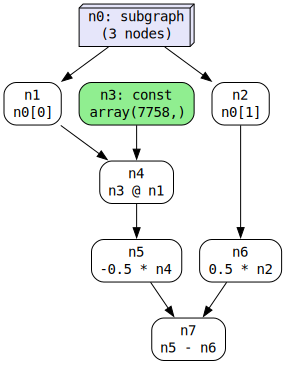

In [136]:
mm.visualize_graph(m.logL.graph)

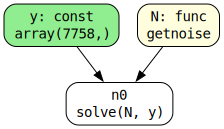

In [137]:
mm.visualize_graph(m.logL.graph.subgraphs[0])

What are the active parameters?

In [138]:
m.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

Sample random values from their priors

In [139]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_efac': 0.9537934013561127,
 'B1855+09_log10_t2equad': -8.023095309139034}

Evaluate the likelihood

In [140]:
p0 = {'B1855+09_efac': 0.9823817963652284,
 'B1855+09_log10_t2equad': -5.0704383291165085}

In [141]:
m.logL(p0)

Array(90015.59241026, dtype=float64)

Try compiled version, grad

In [142]:
jax.jit(m.logL)(p0)

Array(90015.59241026, dtype=float64)

In [143]:
jax.grad(m.logL)(p0)

{'B1855+09_efac': Array(-7158.60488369, dtype=float64, weak_type=True),
 'B1855+09_log10_t2equad': Array(-15401.59491916, dtype=float64, weak_type=True)}

#### Measurement noise only, nanograv backends, free parameters

In [144]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr)])

In [145]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [146]:
p0 = ds.sample_uniform(m.logL.params)

In [147]:
p0 = {'B1855+09_430_ASP_efac': 0.9154776829704399,
 'B1855+09_430_PUPPI_efac': 0.9594992042537276,
 'B1855+09_L-wide_ASP_efac': 0.9532968706207632,
 'B1855+09_L-wide_PUPPI_efac': 1.058473893498841,
 'B1855+09_430_ASP_log10_t2equad': -5.475507301742264,
 'B1855+09_430_PUPPI_log10_t2equad': -5.3544076359051065,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.82792998606614,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -5.338371423768052}

In [148]:
m.logL(p0)

Array(90790.47804475, dtype=float64)

#### Measurement noise only, nanograv backends, parameters from noisedict

In [149]:
psr.noisedict

{'B1855+09_430_ASP_efac': 1.115935306813982,
 'B1855+09_430_ASP_log10_t2equad': -7.564164330699591,
 'B1855+09_430_PUPPI_efac': 1.000049037085653,
 'B1855+09_430_PUPPI_log10_t2equad': -6.572540211467256,
 'B1855+09_L-wide_ASP_efac': 1.043114017270374,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.517929916655293,
 'B1855+09_L-wide_PUPPI_efac': 1.1118432332882,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -7.755603780476984,
 'B1855+09_430_ASP_log10_ecorr': -6.798122106550257,
 'B1855+09_430_PUPPI_log10_ecorr': -5.6989064141929715,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.120457109433745,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641667916624413,
 'B1855+09_red_noise_log10_A': -13.940953818371378,
 'B1855+09_red_noise_gamma': -3.68432133461766}

In [150]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict)])

In [151]:
m.logL.params

[]

In [152]:
m.logL({})

Array(96686.81011374, dtype=float64)

In [153]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(96686.81011374, dtype=float64), {})

#### Add ECORR noise (GP), free params

In [154]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr)])

In [155]:
p0 = ds.sample_uniform(m.logL.params)

In [156]:
mm.print_graph(m.logL.graph)

## graph
y: const = array(7758,)
F: const = array(7758, 360)
Pinv: graph = subgraph Pinv[127c]
n0: graph = subgraph n0[ee19]
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: graph = subgraph n3[a89b]
n4: node(n3) = n3[0]
n6: node(n4, y) = n4.T @ y
n7: node(F, n4) = F.T @ n4
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: node(y, n1) = y.T @ n1
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 2800638 elements

## subgraph Pinv[127c]
P: func = <function makegp_ecorr.<locals>.getphi at 0x3e0cdd760>
n0: node(P) = inv(P)
# total array constants: 0 elements

## subgraph n0[ee19]
y: const = array(7758,)
N: func = <function makenoise_measurement.<locals>.getnoise at 0x3f87d77e0>
n

5601276

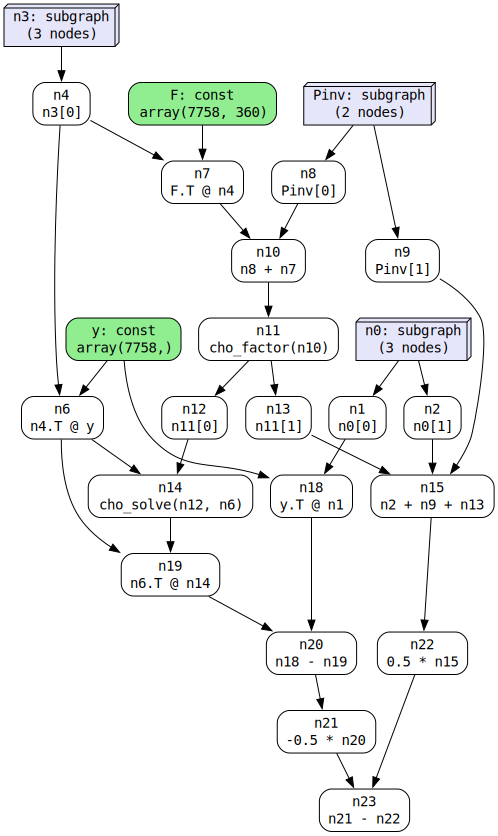

In [157]:
mm.visualize_graph(m.logL.graph)

In [158]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [159]:
p0 = ds.sample_uniform(m.logL.params)

In [160]:
m.logL(p0)

Array(99720.46458579, dtype=float64)

In [161]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(99720.46458579, dtype=float64),
 {'B1855+09_430_ASP_efac': Array(-292.9897073, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_ecorr': Array(-6.49575864, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_t2equad': Array(-660.34370346, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_efac': Array(-676.85764961, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_ecorr': Array(-60.41989382, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_t2equad': Array(-1026.34260588, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_efac': Array(-466.88458327, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_ecorr': Array(-125.25523024, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_t2equad': Array(-704.53262776, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_efac': Array(472.53244024, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_log10_ecorr': Array(-244.8894535, dtype=float64, weak_type=True),
  'B18

#### Add ECORR noise (GP), noisedict params

In [162]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict)])

In [163]:
m.logL.params

[]

In [164]:
m.logL({})

Array(100267.11920383, dtype=float64)

In [165]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(100267.11920383, dtype=float64), {})

#### Add timing model

In [166]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True)])

In [167]:
m.logL.params

[]

In [168]:
m.logL({})

Array(90998.49655392, dtype=float64)

In [169]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(90998.49655392, dtype=float64), {})

#### Add red noise (powerlaw)

In [170]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [171]:
m.logL.params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [172]:
mm.print_graph(m.logL.graph)

## graph
Pinv: graph = subgraph Pinv[4d86]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[4d86]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x3f87fc7c0>
n0: node(P) = inv(P)
# total array constants: 0 elements


3662

In [173]:
p0 = ds.sample_uniform(m.logL.params)

In [174]:
m.logL(p0)

Array(91089.40946563, dtype=float64)

In [175]:
m.logL.params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [176]:
jlogl = jax.jit(m.logL)

In [177]:
jlogl(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(91089.40946563, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.39994618, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(8.4674072, dtype=float64, weak_type=True)})

In [178]:
%timeit jlogl(p0).block_until_ready()

33.5 μs ± 1.73 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Add red noise (powerlaw, fixed gamma)

In [179]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.partial(ds.powerlaw, gamma=4.33), components=30, name='rednoise')])

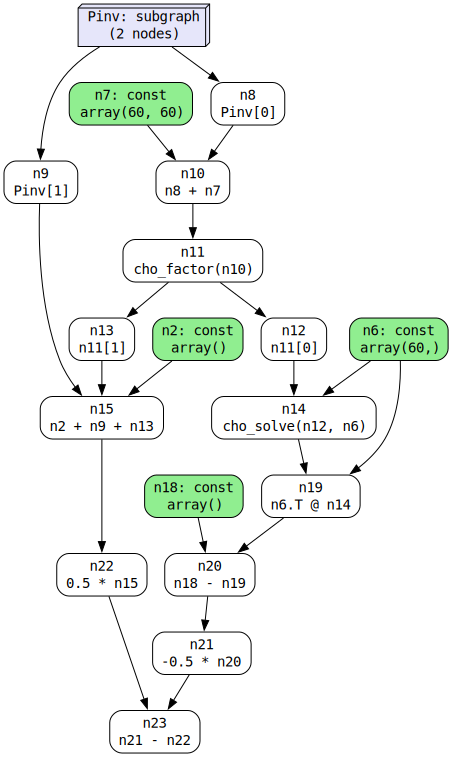

In [180]:
mm.visualize_graph(m.logL.graph)

In [181]:
m.logL.params

['B1855+09_rednoise_log10_A']

In [182]:
p0 = ds.sample_uniform(m.logL.params)

In [183]:
m.logL(p0)

Array(91077.16165397, dtype=float64)

In [184]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(91077.16165397, dtype=float64),
 {'B1855+09_rednoise_log10_A': Array(-36.25070298, dtype=float64, weak_type=True)})

In [185]:
mm.print_graph(m.logL.graph)

## graph
Pinv: graph = subgraph Pinv[78c1]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[78c1]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x3f87ff9c0>
n0: node(P) = inv(P)
# total array constants: 0 elements


3662

Try out `sample_conditional`, obtained by a shortening of the `woodbury` graph.

In [186]:
cond = m.conditional

In [187]:
cond(p0)

(Array([ 2.17555345e-07, -2.20010856e-06, -1.77172753e-07, -4.09479241e-07,
         3.42825172e-07,  4.55670557e-07, -3.13668743e-07,  1.61713576e-07,
        -1.41729214e-07, -6.12987501e-08,  1.19302073e-07, -1.28600500e-08,
         5.08987497e-08,  5.51921784e-08, -4.59676299e-08,  8.54270957e-08,
        -3.00249999e-08, -4.84685839e-08, -2.12809579e-08,  3.23153159e-08,
        -1.24453297e-08, -3.08396798e-08, -3.99625863e-09, -1.49079283e-08,
         6.23671156e-09,  1.25160644e-08, -1.38190372e-08,  9.71403795e-09,
         1.13595142e-09, -1.02479526e-09,  1.58959755e-09,  5.93282950e-10,
         8.43565738e-09,  8.46215995e-09,  5.11077776e-09,  2.67601809e-10,
         9.31013857e-09,  3.75664007e-09,  3.21399550e-09,  1.02803550e-08,
         3.66215855e-09,  1.18252334e-08, -6.78623573e-10, -9.08804178e-12,
        -5.90809004e-10,  1.50488396e-09,  4.88928322e-09,  6.36719326e-12,
         1.96838353e-10, -3.58403280e-09,  9.52840063e-10, -1.49108140e-09,
         9.6

In [188]:
scond = m.sample_conditional

In [189]:
scond(jax.random.PRNGKey(0), p0)

(Array([1797259609, 2579123966], dtype=uint32),
 {'B1855+09_rednoise_coefficients(60)': Array([ 1.70881956e-07, -2.24235703e-06, -2.37383984e-07, -4.10732768e-07,
          3.26461928e-07,  3.82182280e-07, -2.20631308e-07,  1.69593960e-07,
         -1.66918983e-07,  5.99091703e-08,  1.75221309e-07, -3.49481394e-08,
         -7.43900294e-10,  4.04115400e-08, -8.86639390e-08,  7.78343107e-08,
         -1.17995273e-08, -3.54102148e-08,  6.42543792e-08,  1.15625038e-07,
          4.34847573e-08, -5.26331731e-08,  1.56160076e-08, -2.31446867e-08,
          3.13194376e-08,  8.66386429e-08, -5.34897551e-09,  5.83804006e-08,
          2.11214113e-08,  3.06262081e-08, -3.55554018e-09, -1.48071770e-08,
         -2.97810096e-08,  2.60338985e-08, -1.59381458e-08, -2.29344009e-08,
          3.53842245e-08,  4.37697517e-09, -7.17446631e-09, -2.06807815e-09,
          6.37984995e-09,  2.35476315e-08,  1.31449534e-08,  6.72023757e-09,
         -5.73509557e-09, -6.31949187e-09, -1.19518629e-09, -9.8306

Coefficient likelihood

In [190]:
clogl = m.clogL

In [191]:
clogl.params

['B1855+09_rednoise_coefficients(60)', 'B1855+09_rednoise_log10_A']

In [192]:
mm.print_graph(clogl.graph)

## graph
y: const = array(7758,)
F: const = array(7758, 60)
getc: func = <function WoodburyKernel.make_coefficientproduct.<locals>.getc at 0x419785a80>
n0: node(F, getc) = F @ getc
n1: node(y, n0) = y - n0
Nsolve_n2: graph = subgraph Nsolve_n2[5238]
n2: node(Nsolve_n2, n1) = Nsolve(n1)
n3: node(n2) = n2[0]
n4: node(n2) = n2[1]
Psolve_n5: graph = subgraph Psolve_n5[df78]
n5: node(Psolve_n5, getc) = Psolve(getc)
n6: node(n5) = n5[0]
n7: node(n5) = n5[1]
n8: node(n1) = n1.T
n9: node(n8, n3) = n8 @ n3
n10: node(getc) = getc.T
n11: node(n10, n6) = n10 @ n6
n12: node(n9, n11) = n9 + n11
n13: node(n12, n7) = n12 + n7
n14: node(n13, n4) = n13 + n4
n15: node(n14) = -0.5 * n14
# total array constants: 473238 elements

## subgraph Nsolve_n2[5238]
y: arg
Nsolve_n0: graph = subgraph Nsolve_n0[0264]
n0: node(Nsolve_n0, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n4: const = array(7758, 526)
n6: node(n4, y) = n4.T @ y
n9: const = array()
n12: const = array(526, 526), True
n13: const = ar

4838382

In [193]:
clogl({**p0, **scond(jax.random.PRNGKey(0), p0)[1]})

Array(92090.1888402, dtype=float64)

#### Add red noise (free spectrum)

In [194]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.freespectrum, components=30, name='rednoise')])

In [195]:
m.logL.params

['B1855+09_rednoise_log10_rho(30)']

In [196]:
p0 = {'B1855+09_rednoise_log10_rho(30)': 1e-6 * np.random.randn(30)}

In [197]:
m.logL(p0)

Array(90205.41583116, dtype=float64)

In [198]:
mm.print_graph(m.logL.graph, fold=True)

## graph
Pinv: graph = subgraph Pinv[e15f]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[e15f]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x40c8c3100>
n0: node(P) = inv(P)
# total array constants: 0 elements


3662

In [199]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(90205.41583116, dtype=float64),
 {'B1855+09_rednoise_log10_rho(30)': Array([-4.60516845, -4.60517007, -4.60517016, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517018, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517019, -4.60517018, -4.60517014,
         -4.60517013, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],      dtype=float64)})

### Multiple pulsars

In [250]:
psrs = allpsrs[:67]

#### Combined likelihood

In [201]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                        for psr in psrs])

In [202]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

In [203]:
for graph in m.logL.graphs:
    mm.print_graph(graph); print('', end='\n')

## graph
Pinv: graph = subgraph Pinv[ebd7]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[ebd7]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x419786660>
n0: node(P) = inv(P)
# total array constants: 0 elements

## graph
Pinv: graph = subgraph Pinv[e073]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n

In [204]:
p0 = ds.sample_uniform(m.logL.params)

In [205]:
# p0 = {'B1855+09_rednoise_gamma': 1.3138772930930416,
#  'B1855+09_rednoise_log10_A': -17.6973773044854,
#  'B1937+21_rednoise_gamma': 5.138854166981884,
#  'B1937+21_rednoise_log10_A': -18.37138668421632,
#  'B1953+29_rednoise_gamma': 2.740277693849858,
#  'B1953+29_rednoise_log10_A': -15.896408518581373}

In [206]:
m.logL(p0)

Array(473766.2395983, dtype=float64)

In [207]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(473766.2395983, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(0.10262981, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(0.17342224, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(-10.31346678, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(-15.22908748, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(3.68666192, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(19.93050127, dtype=float64, weak_type=True)})

#### Add common noise

Indicating parameters under common shares them among pulsars

In [208]:
T = ds.getspan(psrs)

In [209]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, T=T, name='rednoise'),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=14, T=T, name='crn',
                                                               common=['crn_log10_A', 'crn_gamma'])])
                        for psr in psrs])

In [210]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [211]:
for psr, graph in zip(psrs, m.logL.graphs):
    mm.print_graph(graph, name=psr.name); print('', end='\n')

## B1855+09
Pinv: graph = subgraph Pinv[3d7f]
n2: const = array()
n6: const = array(88,)
n7: const = array(88, 88)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 7834 elements

## subgraph Pinv[3d7f]
P: graph = subgraph P[8eba]
n0: node(P) = inv(P)
# total array constants: 0 elements

## subgraph P[8eba]
a: func = <function makegp_fourier.<locals>.priorfunc at 0x419786340>
b: func = <function makegp_fourier.<locals>.priorfunc at 0x43147e8e0>
n0: node(a, b) = <function concat.<locals>.<lambda> at 0x43147eac0>
# total array constants: 0 elements

## B1937+21
Pinv: graph = subgraph Pinv[c005]
n2: const = arr

In [212]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_rednoise_gamma': 6.675184905207607,
 'B1855+09_rednoise_log10_A': -11.268454334333637,
 'B1937+21_rednoise_gamma': 6.077381832734619,
 'B1937+21_rednoise_log10_A': -11.77542125167423,
 'B1953+29_rednoise_gamma': 4.425316701644791,
 'B1953+29_rednoise_log10_A': -14.327167178417591,
 'crn_gamma': 5.415915428902611,
 'crn_log10_A': -14.653098576339227}

In [213]:
# p0 = {'B1855+09_rednoise_gamma': 4.393246413466512,
#  'B1855+09_rednoise_log10_A': -13.40258009298283,
#  'B1937+21_rednoise_gamma': 6.962929660446664,
#  'B1937+21_rednoise_log10_A': -14.279437020259682,
#  'B1953+29_rednoise_gamma': 6.629185927710269,
#  'B1953+29_rednoise_log10_A': -16.940946338152244,
#  'crn_gamma': 5.554819975636826,
#  'crn_log10_A': -16.898578025214864}

In [214]:
m.logL(p0)

Array(473485.07122632, dtype=float64)

In [215]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(473485.07122632, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(-9.05935824, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(-119.47274854, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(-8.41861186, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(-123.46073707, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(3.82953521, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(12.63028278, dtype=float64, weak_type=True),
  'crn_gamma': Array(4.01325726, dtype=float64, weak_type=True),
  'crn_log10_A': Array(12.01770827, dtype=float64, weak_type=True)})

#### Parallelize red components

Coordinated timespan is required

In [216]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = [ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                                   ds.makecommongp_fourier(psrs, ds.powerlaw, components=14, T=T, name='crn',
                                                           common=['crn_log10_A', 'crn_gamma'])])

In [217]:
test = ds.makecommongp_fourier(psrs, ds.powerlaw, components=14, T=T, name='crn',
                                                           common=['crn_log10_A', 'crn_gamma'])

In [218]:
test.Phi.N

<function discovery.signals.makecommongp_fourier.<locals>.priorfunc(params)>

In [219]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [220]:
mm.print_graph(m.logL.graph)

## graph
Pinv: graph = subgraph Pinv[1f51]
n39: const = array()
n40: const = array(3, 88)
n41: const = array(3, 88, 88)
n42: node(Pinv) = Pinv[0]
n43: node(Pinv) = Pinv[1]
n44: node(n42, n41) = n42 + n41
n45: node(n44) = cho_factor(n44)
n46: node(n45) = n45[0]
n47: node(n45) = n45[1]
n48: node(n46, n40) = cho_solve(n46, n40)
n49: node(n40, n48) = n40 * n48
n50: node(n49) = sum(n49)
n51: node(n39, n50) = n39 - n50
n52: node(n51) = -0.5 * n51
n53: node(n43) = sum(n43)
n54: node(n47) = sum(n47)
n55: node(n53, n54) = n53 + n54
n56: node(n55) = 0.5 * n55
n57: node(n52, n56) = n52 - n56
# total array constants: 23497 elements

## subgraph Pinv[1f51]
P: graph = subgraph P[0490]
n0: node(P) = inv(P)
# total array constants: 0 elements

## subgraph P[0490]
a: func = <function makecommongp_fourier.<locals>.priorfunc at 0x4197fc360>
b: func = <function makecommongp_fourier.<locals>.priorfunc at 0x4635d3ce0>
n0: node(a, b) = <function concat.<locals>.<lambda> at 0x419786520>
# total array constant

23497

In [221]:
p0 = ds.sample_uniform(m.logL.params)

In [222]:
m.logL(p0)

Array(428775.43857404, dtype=float64)

In [223]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(428775.43857404, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(7.14366287e-06, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(1.32041499e-05, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(13.67304593, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(23.25207708, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(4.61131219e-09, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(1.52467271e-08, dtype=float64, weak_type=True),
  'crn_gamma': Array(247.63039298, dtype=float64, weak_type=True),
  'crn_log10_A': Array(444.42153459, dtype=float64, weak_type=True)})

In [224]:
cond = m.conditional

In [225]:
cond(p0)

(Array([[ 6.94863585e-15, -2.91487007e-14,  8.35405957e-15,
         -3.20301282e-16,  3.59877515e-15, -7.32135401e-16,
          9.03866467e-16,  1.75096724e-16, -3.10100214e-16,
          1.01010986e-17, -2.60905535e-16,  4.19497022e-16,
         -8.14880751e-17,  2.27611293e-16,  3.31841414e-17,
          1.96687156e-17,  9.13298050e-17, -1.66990471e-17,
          1.12339064e-18,  5.38713063e-17, -2.80443074e-17,
          3.36425355e-17, -1.88524151e-17,  1.44796028e-17,
         -1.59615915e-18, -1.79639602e-17, -1.53430153e-17,
         -4.03087480e-17, -2.11481466e-17,  1.30740208e-17,
          6.65035136e-20, -5.62536930e-19,  2.98365257e-17,
          1.44276239e-17,  2.05528752e-17, -3.85870176e-18,
         -1.59594961e-17, -1.66042267e-17,  1.02083926e-17,
         -1.87269107e-17,  1.93235871e-17,  1.80003419e-17,
          5.46282389e-18,  2.27125410e-17, -4.58604983e-18,
          1.34521231e-17, -6.73035232e-18,  4.82022365e-18,
         -9.70264084e-18,  1.56933835e-1

In [226]:
scond = m.sample_conditional

In [227]:
scond(jax.random.PRNGKey(0), p0)

(Array([1797259609, 2579123966], dtype=uint32),
 {'B1855+09': Array([-2.11281137e-11,  2.15775366e-11,  4.69832202e-12,  1.50457679e-12,
          1.23678578e-12,  2.61623783e-12,  3.21961897e-12,  4.57023116e-12,
         -4.26751929e-12,  3.40053834e-12, -1.86205073e-12,  1.00018178e-12,
         -1.16240089e-12,  8.74745599e-13,  6.13515974e-13, -1.77317636e-13,
          1.50657792e-12,  6.41570134e-13,  2.86688400e-12,  2.36461057e-12,
          1.87824889e-12,  1.84328677e-13,  9.66556261e-13,  4.90065488e-13,
          8.14551674e-13,  2.60356295e-12,  3.50914234e-13,  1.45987402e-12,
          5.36312569e-13,  9.29898663e-13, -2.00119938e-13, -4.81321465e-13,
         -1.36988121e-12,  5.08945608e-13, -7.13587495e-13, -8.25843525e-13,
          1.07550343e-12,  8.35824606e-14, -3.78930160e-13, -4.38073512e-13,
          1.47970057e-13,  5.32854361e-13,  6.01852546e-13,  3.00736983e-13,
         -2.60076944e-13, -3.70639138e-13, -2.83083229e-13, -4.85160965e-13,
          4.0892

#### Reuse Fourier vectors

`ds.makepowerlaw_crn` yields the sum of two powerlaws, with possibly different number of components.

In [228]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.makepowerlaw_crn(components=14), components=30, T=T, name='rednoise',
                                                          common=['crn_log10_A', 'crn_gamma']))

In [229]:
p0 = ds.sample_uniform(m.logL.params)

In [230]:
m.logL(p0)

Array(469302.52743636, dtype=float64)

In [231]:
mm.print_graph(m.logL.graph)

## graph
Pinv: graph = subgraph Pinv[25d4]
n39: const = array()
n40: const = array(3, 60)
n41: const = array(3, 60, 60)
n42: node(Pinv) = Pinv[0]
n43: node(Pinv) = Pinv[1]
n44: node(n42, n41) = n42 + n41
n45: node(n44) = cho_factor(n44)
n46: node(n45) = n45[0]
n47: node(n45) = n45[1]
n48: node(n46, n40) = cho_solve(n46, n40)
n49: node(n40, n48) = n40 * n48
n50: node(n49) = sum(n49)
n51: node(n39, n50) = n39 - n50
n52: node(n51) = -0.5 * n51
n53: node(n43) = sum(n43)
n54: node(n47) = sum(n47)
n55: node(n53, n54) = n53 + n54
n56: node(n55) = 0.5 * n55
n57: node(n52, n56) = n52 - n56
# total array constants: 10981 elements

## subgraph Pinv[25d4]
P: func = <function makecommongp_fourier.<locals>.priorfunc at 0x49883e980>
n0: node(P) = inv(P)
# total array constants: 0 elements


10981

In [232]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(469302.52743636, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(0.02464835, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(0.04218188, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(6044.36150559, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(11962.86454737, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(5.51321513e-08, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(1.24881591e-07, dtype=float64, weak_type=True),
  'crn_gamma': Array(245.96963855, dtype=float64, weak_type=True),
  'crn_log10_A': Array(532.9320164, dtype=float64, weak_type=True)})

#### Add global spatially correlated process

In [233]:
# importlib.reload(mh)

Note `ds.makeglobalgp_fourier` requires the ORF, but not the `common` specification, which is automatic.

In [251]:
test = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw')
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                       globalgp = test)

/Users/pmeyers/miniforge3/envs/discovery/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/pmeyers/miniforge3/envs/discovery/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/pmeyers/miniforge3/envs/discovery/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2374: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


In [252]:
test = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw')

In [253]:
test.inv = test.Phi_inv

In [254]:
p0 = ds.sample_uniform(m.logL.params)

In [255]:
m.logL(p0)

Array(7970344.54048814, dtype=float64)

There's still some redundant storage of F matrices in the K solvers as applied to the top level y and F. We should probably write an integrated GlobalVectorWoodbury that does everything in-house; then the constants would be folded appropriately.

In [256]:
mm.print_graph(mm.prune_graph(mm.fold_constants(m.logL.graph)))

## graph
projected: graph = subgraph projected[0c63]
Pinv: graph = subgraph Pinv[d8fa]
n0: node(projected) = projected[0]
n1: node(projected) = projected[1]
n2: node(projected) = projected[2]
n3: node(projected) = projected[3]
n4: node(n0) = sum(n0)
n5: node(n1) = sum(n1)
n6: node(n2) = <function globalwoodbury_fused.<locals>.<lambda> at 0x3c65942c0>
n7: node(n3) = <function globalwoodbury_fused.<locals>.<lambda> at 0x3c6594360>
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n6, n14) = n6.T @ n14
n16: node(n4, n15) = n4 - n15
n17: node(n16) = -0.5 * n16
n18: node(n9) = sum(n9)
n19: node(n18, n5) = n18 + n5
n20: node(n19, n13) = n19 + n13
n21: node(n20) = 0.5 * n20
n22: node(n17, n21) = n17 - n21
# total array constants: 0 elements

## subgraph projected[0c63]
Pinv: graph = subgraph Pinv[f3cc]
n737: const = array(67, 60)
n738: 

524878

In [257]:
jlogl = jax.jit(m.logL)

In [258]:
jlogl(p0)

Array(7970344.54048814, dtype=float64)

In [259]:
%%timeit
jlogl(p0).block_until_ready()

55.7 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [243]:
jax.jit(jax.grad(m.logL))(p0)

{'B1855+09_rednoise_gamma': Array(0.00235315, dtype=float64, weak_type=True),
 'B1855+09_rednoise_log10_A': Array(0.00604892, dtype=float64, weak_type=True),
 'B1937+21_rednoise_gamma': Array(0.77491412, dtype=float64, weak_type=True),
 'B1937+21_rednoise_log10_A': Array(1.83986303, dtype=float64, weak_type=True),
 'B1953+29_rednoise_gamma': Array(7.4567446e-09, dtype=float64, weak_type=True),
 'B1953+29_rednoise_log10_A': Array(2.55967279e-08, dtype=float64, weak_type=True),
 'gw_gamma': Array(339.21105144, dtype=float64, weak_type=True),
 'gw_log10_A': Array(603.23320398, dtype=float64, weak_type=True)}

#### Another way of doing this (useful if variable GPs differ among pulsars)

In [244]:
m = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')]) for psr in psrs],
                        globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

In [245]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'gw_gamma',
 'gw_log10_A']

In [246]:
p0 = ds.sample_uniform(m.logL.params)

In [247]:
m.logL(p0)

Array(473547.67691462, dtype=float64)

In [248]:
mm.print_graph(m.logL.graph)

## graph
ys_0: const = array(7758,)
ys_1: const = array(23023,)
ys_2: const = array(5126,)
Fs_0: const = array(7758, 28)
Fs_1: const = array(23023, 28)
Fs_2: const = array(5126, 28)
Pinv: graph = subgraph Pinv[eb92]
n0: graph = subgraph n0[5635]
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: graph = subgraph n3[9168]
n4: node(n3) = n3[0]
n6: node(ys_0, n1) = ys_0.T @ n1
n7: node(n6, n2) = n6 + n2
n8: node(n4, ys_0) = n4.T @ ys_0
n9: node(Fs_0, n4) = Fs_0.T @ n4
n10: graph = subgraph n10[ec44]
n11: node(n10) = n10[0]
n12: node(n10) = n10[1]
n13: graph = subgraph n13[f440]
n14: node(n13) = n13[0]
n16: node(ys_1, n11) = ys_1.T @ n11
n17: node(n16, n12) = n16 + n12
n18: node(n14, ys_1) = n14.T @ ys_1
n19: node(Fs_1, n14) = Fs_1.T @ n14
n20: graph = subgraph n20[7a50]
n21: node(n20) = n20[0]
n22: node(n20) = n20[1]
n23: graph = subgraph n23[7a89]
n24: node(n23) = n23[0]
n26: node(ys_2, n21) = ys_2.T @ n21
n27: node(n26, n22) = n26 + n22
n28: node(n24, ys_2) = n24.T @ ys_2
n29: node(Fs_2, n24

6418272

In [249]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(473547.67691462, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(5.49348535e-05, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(9.32368462e-05, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(-8.22940956, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(-129.54044803, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(0.33750527, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(1.35648114, dtype=float64, weak_type=True),
  'gw_gamma': Array(0.00520294, dtype=float64, weak_type=True),
  'gw_log10_A': Array(0.00972814, dtype=float64, weak_type=True)})